<a href="https://colab.research.google.com/github/sungkim11/forecast-sales/blob/main/forecast_sales_using_orbit_lgt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Prequisites

Following are prerequisite for this tutorial:

- Data
- Python Package: orbit-ml or Uber Orbit

### 1.1. Data

Three data sources were used for this tutorial where United Stated Census Bureau Monthly Retail Sales is used to forecast future sales and both FRED Data and OECD Data were used as Regressors data.

**United Stated Census Bureau Monthly Retail Sales**
United Stated Census Bureau maintains Monthly Retail Trade Report, from January 1992 to Present. This data was picked to illustrate forecasting because it has extensive historical data with same monthly frequency. Data is available as Excel spreadsheet format at https://www.census.gov/retail/mrts/www/mrtssales92-present.xls

**FRED Data: https://fred.stlouisfed.org/**

- Inflation
- CPI
- M1
- M2
- Interest Rate

**OECD Data: https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart**

- Composite leading indicator (CLI)
- Business confidence index (BCI)
- Consumer confidence index (CCI)

## 1.2. Python Packages

#### 1.2.1. Install Orbit

In [ ]:
!pip install orbit-ml

## 2. Code

### 2.1. Import Python Package

Import python packages and show its version. Showing version is important since it will enable other users to replicate your work using same python version and python packages version.

In [ ]:
import pandas as pd
import matplotlib as plt
import platform

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import orbit
from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data,plot_predicted_components, plot_bt_predictions
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.diagnostics.metrics import smape, wmape

print('Python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('matplotlib: ', plt.__version__)
print('Orbit: ', orbit.__version__)
print('statsmodels: ', statsmodels.__version__)

Python:  3.7.13
pandas:  1.3.5
matplotlib:  3.5.1
Orbit:  1.1.2
statsmodels:  0.13.2


### 2.2. Mount Storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.3. Prep Data

#### Import and validate dataset

In [ ]:
retail_sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/forecast-sales/data/mrtssales92-present-regressors.csv', index_col = None)
retail_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month           205 non-null    object 
 1   sales_total     205 non-null    int64  
 2   inflation_rate  205 non-null    float64
 3   cpi             205 non-null    float64
 4   m1              205 non-null    float64
 5   m2              205 non-null    float64
 6   cli             205 non-null    float64
 7   bci             205 non-null    float64
 8   cci             205 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 14.5+ KB


#### Resize dataset

We will ONLY be using retail sales data from 01/01/2005 thru 12/31/2018.

In [ ]:
retail_sales = retail_sales[:-37]
retail_sales.info()
retail_sales.tail(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month           168 non-null    object 
 1   sales_total     168 non-null    int64  
 2   inflation_rate  168 non-null    float64
 3   cpi             168 non-null    float64
 4   m1              168 non-null    float64
 5   m2              168 non-null    float64
 6   cli             168 non-null    float64
 7   bci             168 non-null    float64
 8   cci             168 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.9+ KB


,month,sales_total,inflation_rate,cpi,m1,m2,cli,bci,cci
163,8/1/2018,520544,2.13,258.028,3664.825,14179.0,99.08091,99.29861,101.1488
164,9/1/2018,477137,2.08,258.505,3678.425,14217.2,98.69699,99.12753,101.0597
165,10/1/2018,503602,2.14,258.997,3727.380,14218.7,98.31645,98.99612,100.9435
166,11/1/2018,518457,2.02,259.455,3664.175,14260.9,97.96261,98.88857,100.8148
167,12/1/2018,556614,1.97,259.934,3814.200,14452.3,97.66416,98.78981,100.7151


#### Convert 'month' column to datetime column.

In [ ]:
retail_sales['month'] = pd.to_datetime(retail_sales.month)
retail_sales.head(5)

,month,sales_total,inflation_rate,cpi,m1,m2,cli,bci,cci
0,2005-01-01,293261,2.53,199.0,1374.700,6406.1,100.2392,103.5195,101.0167
1,2005-02-01,295062,2.48,199.4,1355.000,6404.6,100.2278,103.3132,100.9915
2,2005-03-01,339141,2.69,200.1,1374.675,6462.9,100.1927,103.1299,100.8536
3,2005-04-01,335632,2.69,200.2,1370.775,6517.4,100.1402,103.0560,100.7005
4,2005-05-01,345348,2.60,200.5,1373.980,6453.0,100.0809,103.0645,100.6352


#### Split datasets
- Train
- Test

In [ ]:
retail_sales_train = retail_sales[:-24]
retail_sales_test = retail_sales[-24:]

print('Train: ', retail_sales_train.shape)
print('Test: ', retail_sales_test.shape)

Train:  (144, 9)
Test:  (24, 9)


### 2.4. Exploratory Data Analysis

#### Set Plotting Parameters

In [ ]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 30
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

#### Chart Retail Sales

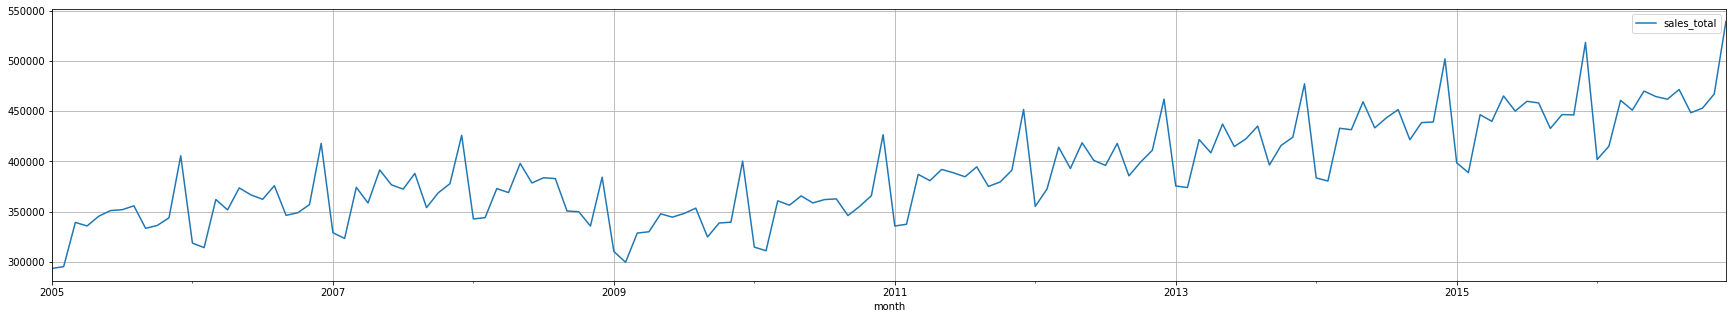

In [ ]:
retail_sales_train.plot(x='month', y='sales_total', kind='line', grid=1)
plt.pyplot.show()

#### Determine Retail Sales Data (Time-Series) has trend

Next, we need to determine if the retail sales data is non-stationary or it has trends using Dickey Fuller Test, which is a statistical hypothesis test that allows you to detect non-stationarity. The stationary time-series implies there is no predictable pattern in the long term.

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(retail_sales_train.sales_total.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -0.41114662261582896
ADF p-values: 0.9082209893408628
ADF number of lags used: 14
ADF number of observations: 129
ADF critical values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}
ADF best information criterion: 2712.938864098956


Looking at the value, which is bigger than 0.05, you can determine time-series data is non-stationary.

### 2.5. Train Forecast Model

#### Develop and fit forecast model

In [ ]:
retail_sales_lgt = LGT(
   response_col='sales_total', 
   date_col='month',
   regressor_col=['cpi'],
   seasonality=12,
)
retail_sales_lgt.fit(df=retail_sales_train)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aea89cc15436811b43e6c7a717ca27b7 NOW.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


#### Predict retail sales (forecast)

In [ ]:
retail_sales_predicted = retail_sales_lgt.predict(df=retail_sales_test, decompose=True)
retail_sales_predicted.head(12)

,month,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2017-01-01,407693.153130,422500.515848,441390.262493,432665.833505,449976.900319,467443.398984,-32651.793435,-28506.452320,-20537.798104,-423.256088,-27.693128,376.378543
1,2017-02-01,407181.207554,431222.150602,451657.197526,426499.640475,450713.795416,473926.094099,-25468.200959,-20846.609209,-12177.258996,-424.153408,-27.751839,377.176480
2,2017-03-01,458596.071853,480564.346434,506496.379971,428985.211468,452707.279693,480723.846687,22377.521585,27059.981614,34350.279781,-424.062155,-27.745868,377.095334
3,2017-04-01,451751.937817,474166.453510,501878.013745,431376.734557,454703.370334,482875.343404,13998.063484,19200.278277,25829.806827,-424.540387,-27.777159,377.520600
4,2017-05-01,474637.362304,495369.544418,522706.157061,431020.691001,454982.429781,483438.265905,35432.145398,41310.681974,47525.673918,-424.883431,-27.799603,377.825650
5,2017-06-01,461994.007624,490301.420774,512482.661341,430879.020471,457583.117377,482946.790080,23651.625219,31452.027198,39475.745270,-425.417429,-27.834542,378.300505
6,2017-07-01,459570.141897,487612.617348,517283.696310,430023.902153,456625.812124,485948.266147,21468.460377,29966.133186,39022.412338,-425.821307,-27.860968,378.659652
7,2017-08-01,463823.184287,494597.855658,518873.455883,425467.744140,458243.484029,484000.691937,27190.526351,35918.011168,45846.349097,-426.750734,-27.921779,379.486141
8,2017-09-01,435794.426746,467137.317934,491366.895586,427105.144162,456625.837858,488320.166325,273.985767,8931.861896,19882.980250,-427.218828,-27.952406,379.902391
9,2017-10-01,436985.591792,475477.982736,503935.761845,423358.070166,458775.854443,492163.186337,7387.888067,14860.559303,25817.717406,-428.425393,-28.031350,380.975324


#### Chart Sales Forecast

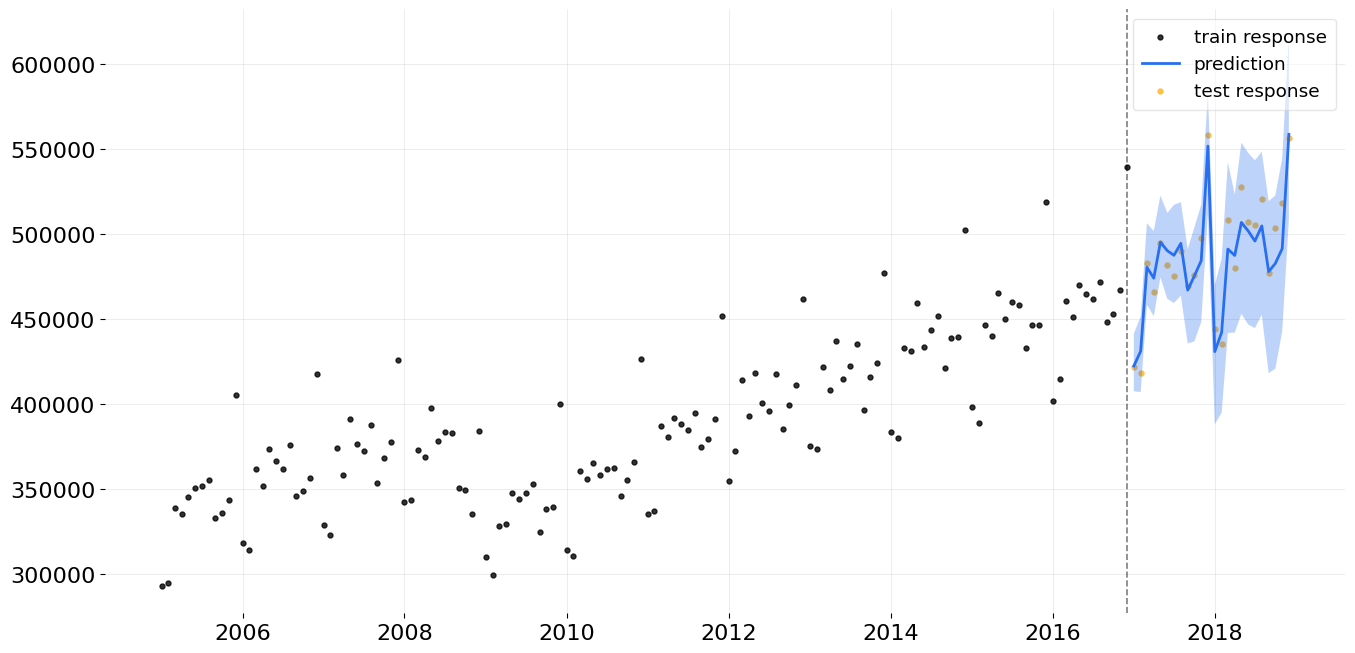

<AxesSubplot:>

In [ ]:
plot_predicted_data(
  training_actual_df=retail_sales_train, 
  predicted_df=retail_sales_predicted, 
  date_col=retail_sales_lgt.date_col, 
  actual_col=retail_sales_lgt.response_col,
  test_actual_df=retail_sales_test
)

#### Chart Sales Forecast Components

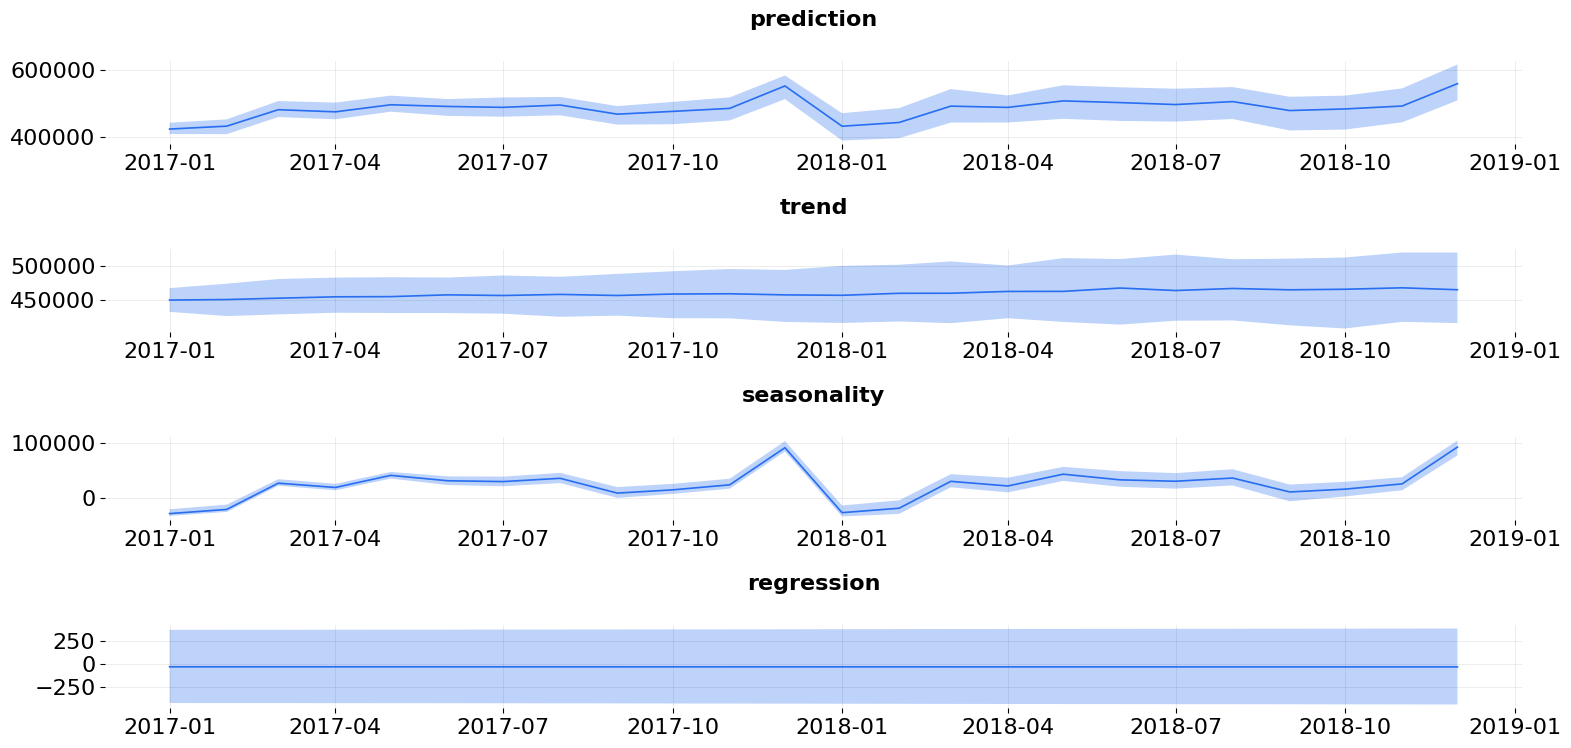

array([<AxesSubplot:title={'center':'prediction'}>,
       <AxesSubplot:title={'center':'trend'}>,
       <AxesSubplot:title={'center':'seasonality'}>,
       <AxesSubplot:title={'center':'regression'}>], dtype=object)

In [ ]:
 plot_predicted_components(retail_sales_predicted, 
                           date_col='month',
                           plot_components=['prediction', 'trend', 'seasonality', 'regression'])

### 2.6. Validate Forecast Model Using Orbit

We will be using expanding train data to validate forecast model.

<AxesSubplot:title={'center':'Train/Test Split Scheme'}, ylabel='Split #'>

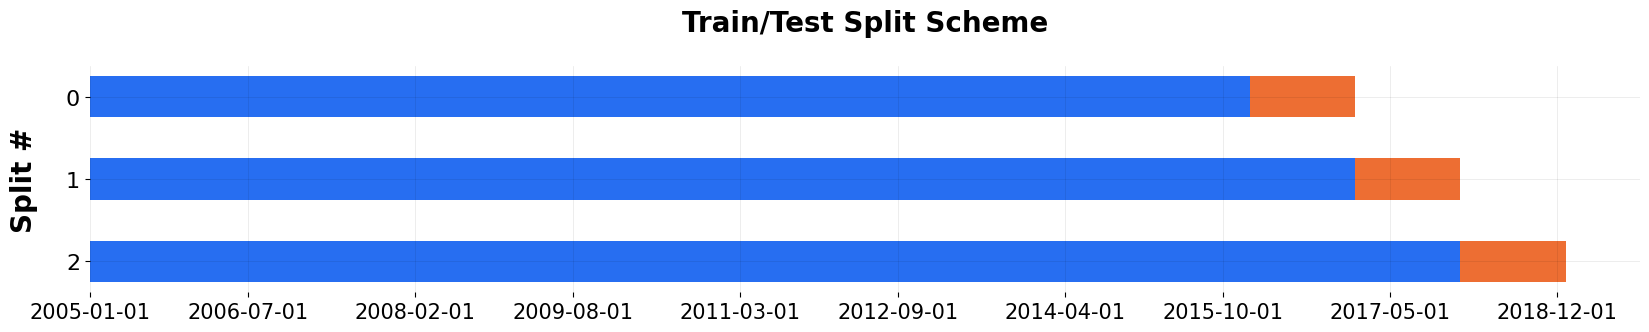

In [ ]:
ex_splitter = TimeSeriesSplitter(retail_sales,
                                  min_train_len=132,
                                  incremental_len=12,
                                  forecast_len=12,
                                  n_splits=3,
                                  window_type='expanding', 
                                  date_col='month')
ex_splitter.plot()

In [ ]:
# configs
min_train_len = 132
forecast_len = 12
incremental_len = 12
window_type = 'expanding'

bt = BackTester(
    model=retail_sales_lgt,
    df=retail_sales,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

In [ ]:
bt.fit_predict()

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


In [ ]:
predicted_df = bt.get_predicted_df()
predicted_df.head()

,date,actual,prediction_5,prediction,prediction_95,training_data,split_key
0,2005-01-01,293261,276284.644649,293270.938012,311058.775121,True,0
1,2005-02-01,295062,274442.898496,295281.525477,309976.460010,True,0
2,2005-03-01,339141,281415.997544,295203.032756,316713.695539,True,0
3,2005-04-01,335632,306269.897535,319691.313378,339221.955079,True,0
4,2005-05-01,345348,309157.459151,327337.387992,347064.360745,True,0


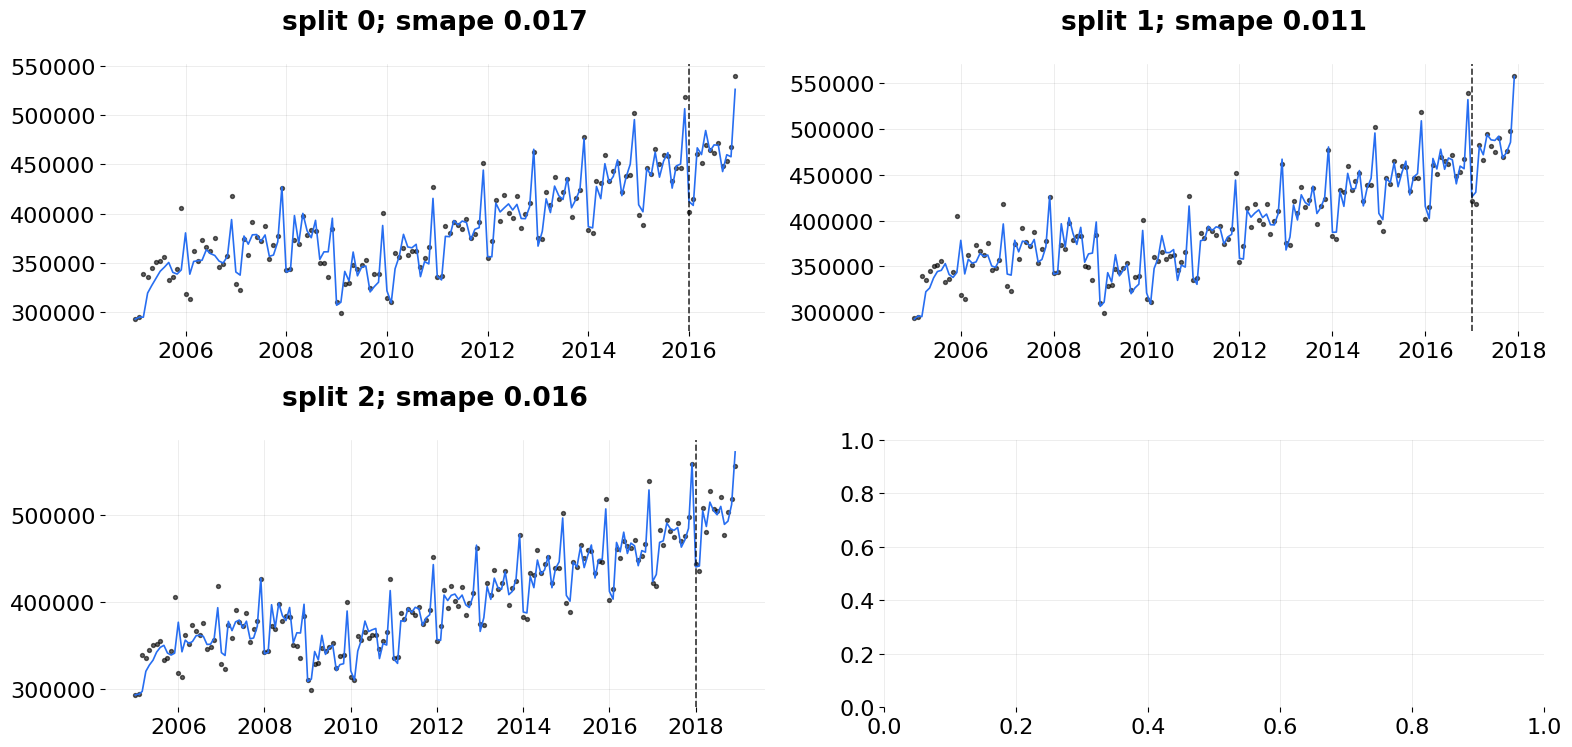

In [ ]:
plot_bt_predictions(predicted_df, metrics=smape, ncol=2, include_vline=True);

In [ ]:
bt.score()

,metric_name,metric_values,is_training_metric
0,smape,1.454310e-02,False
1,wmape,1.453158e-02,False
2,mape,1.457741e-02,False
3,mse,6.768794e+07,False
4,mae,6.952583e+03,False
5,rmsse,1.996043e-01,False


In [ ]:
float("1.457741e-02	")
# and now with 'rounding'
"{:.8f}".format(float("1.457741e-02"))

'0.01457741'

### 2.7. Validate Forecast Model

In [ ]:
retail_sales_validate = predicted_df[-24:]
retail_sales_validate.head(5)

,date,actual,prediction_5,prediction,prediction_95,training_data,split_key
444,2017-01-01,421943,407863.270470,423677.958198,440913.149676,True,2
445,2017-02-01,418315,410025.883297,431775.743233,444950.194052,True,2
446,2017-03-01,483082,450753.516388,468600.105129,484489.969036,True,2
447,2017-04-01,465788,458061.444549,470338.282176,485559.448633,True,2
448,2017-05-01,494621,475809.939276,490769.167906,505562.155821,True,2


In [ ]:
retail_sales_validate['AE'] = (retail_sales_validate['actual'] - retail_sales_validate['prediction']).abs()
retail_sales_validate['APE'] = (retail_sales_validate['actual'] - retail_sales_validate['prediction']).abs()/retail_sales_validate['actual']
retail_sales_validate.loc['MAPE'] = pd.Series(retail_sales_validate['APE'].mean(), index = ['APE'])
retail_sales_validate.loc['Min APE'] = pd.Series(retail_sales_validate['APE'].min(), index = ['APE'])
retail_sales_validate.loc['Max APE'] = pd.Series(retail_sales_validate['APE'].max(), index = ['APE'])
retail_sales_validate.tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,date,actual,prediction_5,prediction,prediction_95,training_data,split_key,AE,APE
461,2018-06-01,507106.0,479293.926203,505127.543133,528592.207689,0.0,2.0,1978.456867,0.003901
462,2018-07-01,505209.0,473472.470001,500297.481899,527005.882126,0.0,2.0,4911.518101,0.009722
463,2018-08-01,520544.0,488393.548968,509946.774192,546121.829155,0.0,2.0,10597.225808,0.020358
464,2018-09-01,477137.0,459570.497168,489310.971082,519507.629798,0.0,2.0,12173.971082,0.025515
465,2018-10-01,503602.0,467422.671626,492989.701397,526540.321373,0.0,2.0,10612.298603,0.021073
466,2018-11-01,518457.0,481480.359833,512020.118877,547169.388095,0.0,2.0,6436.881123,0.012415
467,2018-12-01,556614.0,545042.945397,572525.374727,611332.544329,0.0,2.0,15911.374727,0.028586
MAPE,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014813
Min APE,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002368
Max APE,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032178
